#### DSB-SC Amplitude Modulation 

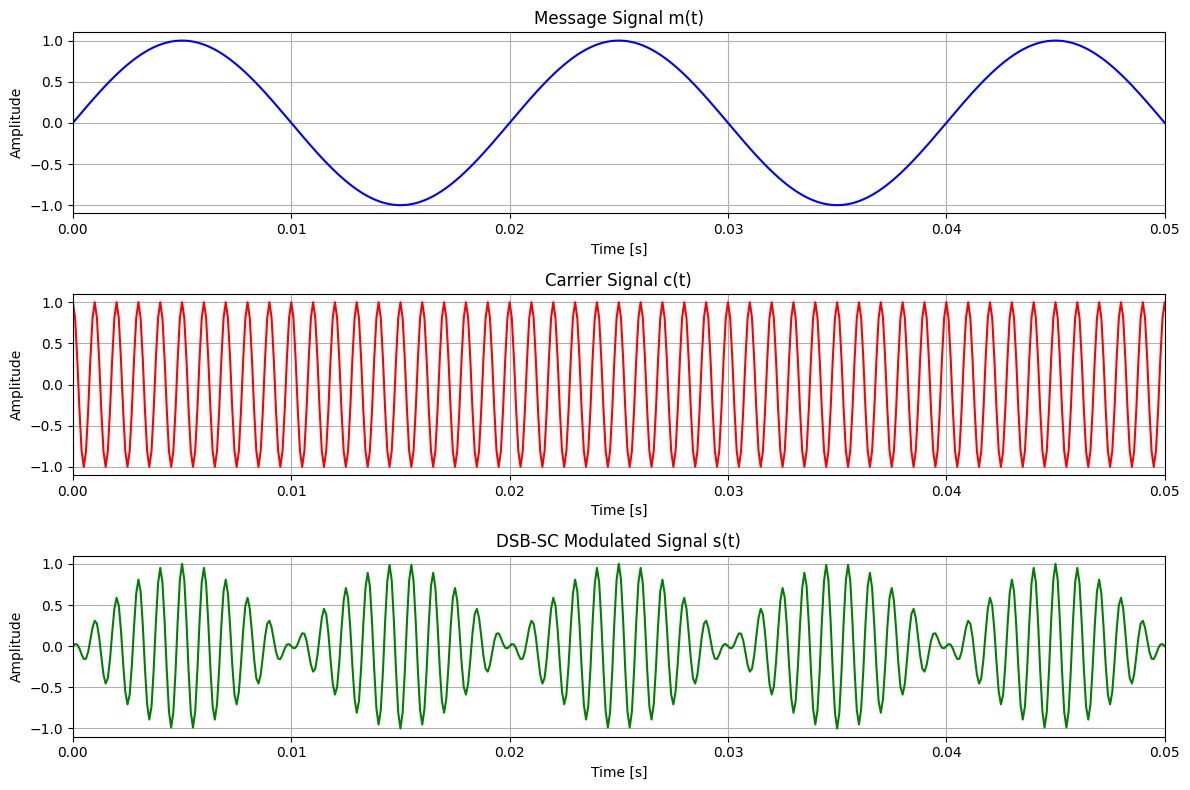

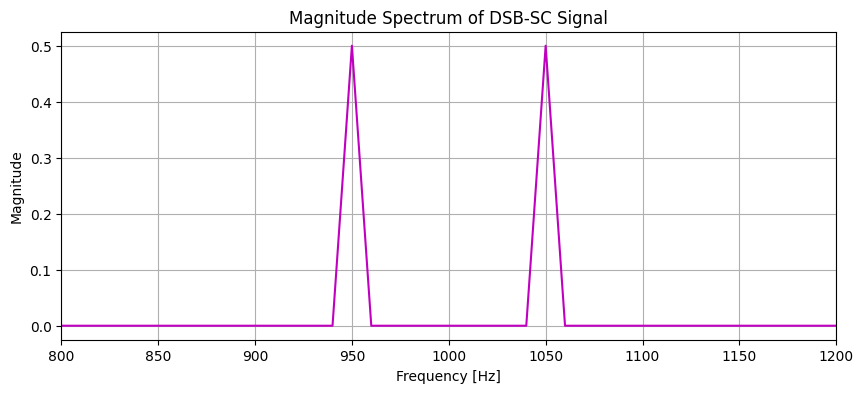

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling Parameters
Fs = 10000                 # Sampling frequency (Hz)
T = 0.1                   # Duration of signal (seconds)
t = np.arange(0, T, 1/Fs)  # Time vector

# Baseband signal (message)
Am = 1                     # Message amplitude
fm = 50                    # Message frequency (Hz)
m_t = Am * np.sin(2 * np.pi * fm * t)

# Carrier signal
fc = 1000                         # Carrier frequency (Hz)
c_t = np.cos(2 * np.pi * fc * t)  # amplitude = 1 for DSB-SC

# DSB-SC Modulated signal
s_dsbsc = m_t * c_t  # No carrier term added

# Time-domain plots
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(t, m_t, 'b', linewidth=1.5)
plt.title('Message Signal m(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, c_t, 'r', linewidth=1.5)
plt.title('Carrier Signal c(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, s_dsbsc, 'g', linewidth=1.5)
plt.title('DSB-SC Modulated Signal s(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.tight_layout()
plt.show()

# Frequency-domain analysis
N = len(s_dsbsc)
S_f = np.fft.fft(s_dsbsc)/N
f = np.fft.fftfreq(N, 1/Fs)

f_pos = f[:N//2]
S_f_pos = 2 * np.abs(S_f[:N//2])

plt.figure(figsize=(10,4))
plt.plot(f_pos, S_f_pos, 'm', linewidth=1.5)
plt.title("Magnitude Spectrum of DSB-SC Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(fc - 200, fc + 200)
plt.show()